In [3]:
import pandas as pd 
import numpy as np

In [4]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',index_col=0, parse_dates=True).dropna()
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [5]:
data = pd.DataFrame(raw['EUR='])

In [6]:
data.rename(columns={'EUR=': 'price'}, inplace=True)
data.head()

,price
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


In [7]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()
data.tail()

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


In [8]:
from pylab import mpl, plt
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

<Axes: title={'center': 'EUR/USD | 42 & 252 days SMAs'}, xlabel='Date'>

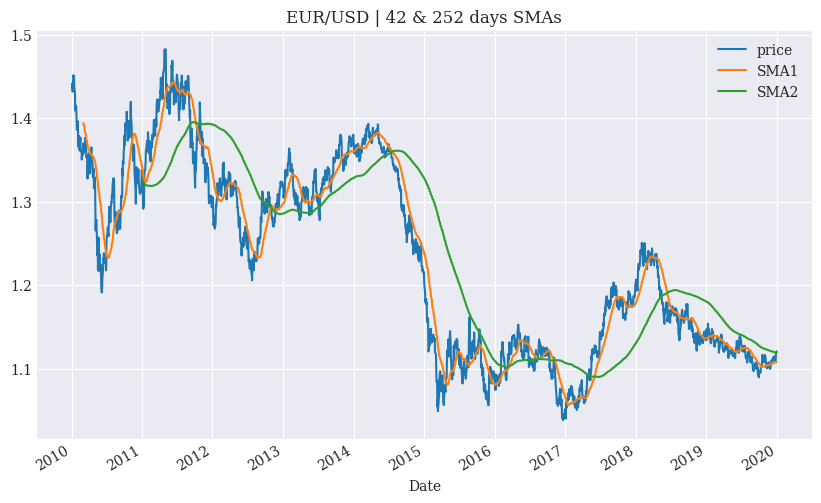

In [9]:
data.plot(title='EUR/USD | 42 & 252 days SMAs', figsize=(10, 6))

In [10]:
# Implements the trading rule in vectorized fashion. np.where() produces 
# +1 for rows where the expression is True 
# and -1 for rows where the expression is False
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

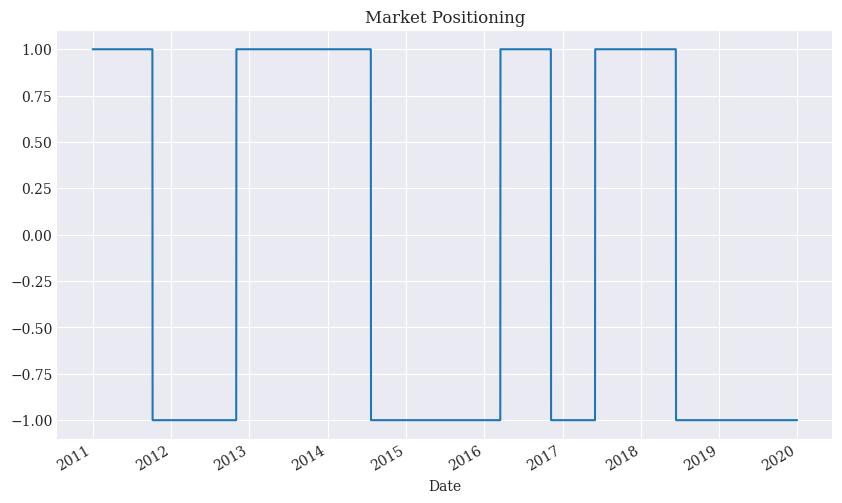

In [11]:
data.dropna(inplace=True)
data['position'].plot(ylim=[-1.1, 1.1], title='Market Positioning', figsize=(10, 6));

<Axes: >

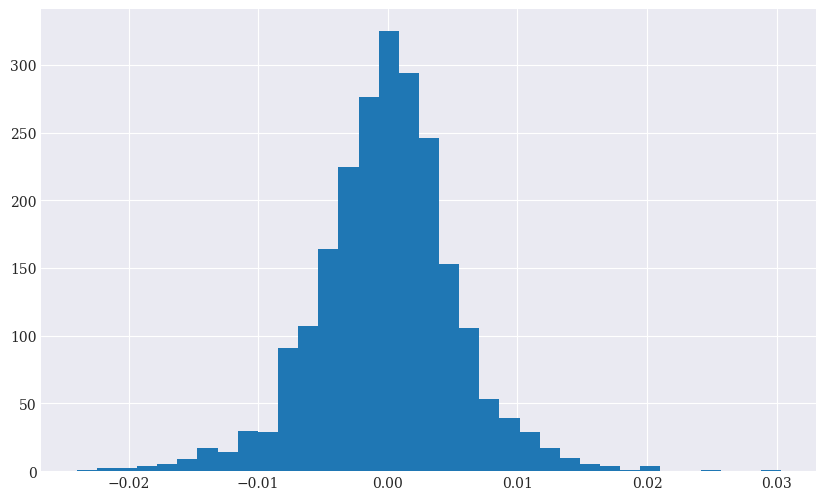

In [12]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))
data['returns'].hist(bins=35, figsize=(10, 6))

In [13]:
# Derives the log returns of the strategy given the positionings and market returns
data['strategy'] = data['position'].shift(1) * data['returns']

In [14]:
data[['returns', 'strategy']].sum()

returns    -0.176731
strategy    0.253121
dtype: float64

In [15]:
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.838006
strategy    1.288039
dtype: float64

<Axes: xlabel='Date'>

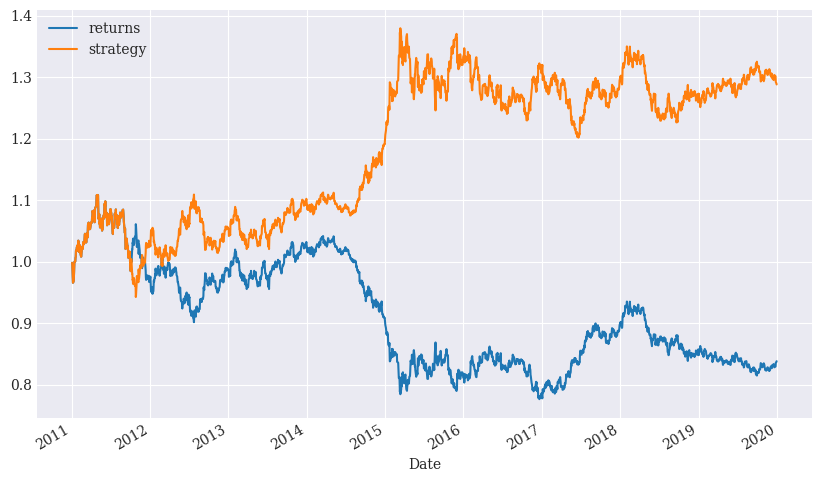

In [17]:
# Calculating the cumulative sum over time with cumsum and, 
# based on this, the cumulative returns by applying the exponential function np.exp() 
# gives a more comprehensive picture of how the strategy compares to the performance 
# of the base financial instrument over time
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Risk statistics

<Axes: xlabel='Date'>

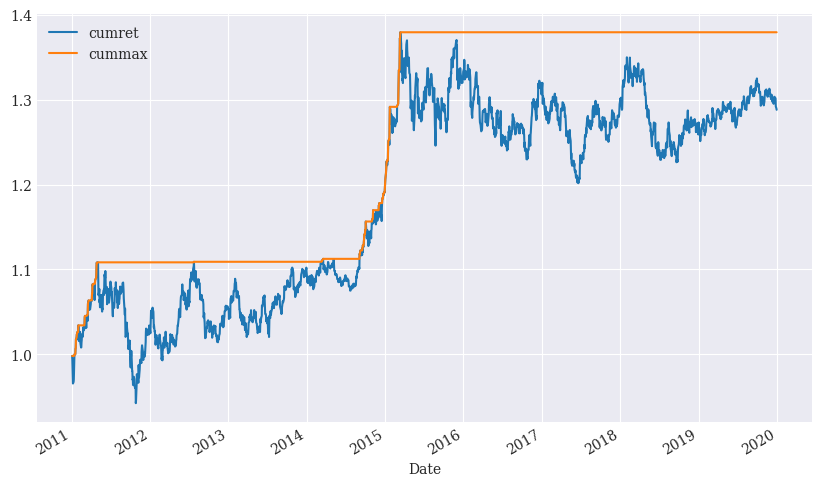

In [18]:
# Cumulative maximum gross performance 
data['cumret'] = data['strategy'].cumsum().apply(np.exp)

# The running maximum value of the gross performance
data['cummax'] = data['cumret'].cummax()
data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6))

In [19]:
data.head()

,price,SMA1,SMA2,position,returns,strategy,cumret,cummax
Date,,,,,,,,
2010-12-31,1.3377,1.342579,1.326218,1,NaN,NaN,NaN,NaN
2011-01-03,1.3351,1.340945,1.325798,1,-0.001946,-0.001946,0.998056,0.998056
2011-01-04,1.3301,1.338940,1.325374,1,-0.003752,-0.003752,0.994319,0.998056
2011-01-05,1.3151,1.336448,1.324874,1,-0.011341,-0.011341,0.983105,0.998056
2011-01-06,1.3001,1.333995,1.324351,1,-0.011472,-0.011472,0.971892,0.998056


In [20]:
# Calculate drawdown
drawdown = data['cummax'] - data['cumret']

drawdown.max()

0.17779367070195895

In [22]:
temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
periods[12:15]
periods.max()

datetime.timedelta(days=596)

The determination of the longest drawdown period is a bit more involved. It requires those dates at which the gross performance equals its cumulative maximum (that is, where a new maximum is set). This information is stored in a temporary object. Then the differences in days between all such dates are calculated and the longest period is picked out. Such periods can be only one day long or more than 100 days. Here, the longest drawdown period lasts for 596 days—a pretty long period

### SMA Backtesting class

In [38]:
from function.SMAVectorBacktester import SMAVectorBacktester as SMA

In [41]:
smabt = SMA('EUR=', 42, 252,
                                         '2010-1-1', '2019-12-31')

In [42]:
smabt.run_strategy()

(np.float64(1.29), np.float64(0.45))

1.29 ~ 129% return of strategy while 0.45 ~ 45% is the outperformance of strategy vs. natural return

In [43]:
smabt.optimize_parameters((30, 50, 2),
                                   (200, 300, 2))

(array([ 48., 238.]), np.float64(1.5))

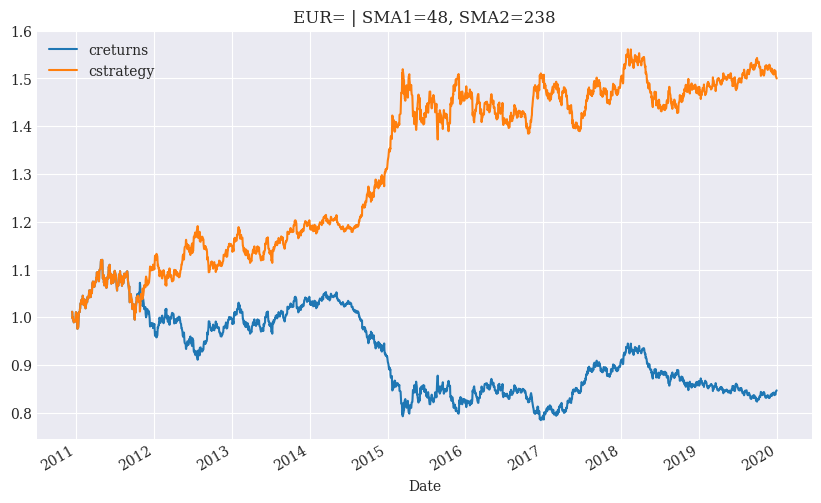

In [44]:
smabt.plot_results()